In [18]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import pickle

### Loading CICIDS2017 Dataset

In [19]:
data_path = Path("../dataset-cicids2017/raw")

filenames = [
	"Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
	"Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
	"Friday-WorkingHours-Morning.pcap_ISCX.csv",
	"Monday-WorkingHours.pcap_ISCX.csv",
	"Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
	"Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
	"Tuesday-WorkingHours.pcap_ISCX.csv",
	"Wednesday-workingHours.pcap_ISCX.csv"
]
    
dfs = []
for file in filenames:
	file_path = data_path / file
	df = pd.read_csv(file_path)
	dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [20]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


### Data Cleaning

In [21]:
print("Initial shape:", data.shape)

## removing duplicates
data = data.drop_duplicates()
print("After dropping duplicates:", data.shape)

## removing Nan/inf values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
print("After removing Nan/inf:", data.shape)

## encoding categorical labels numerically
categorical_cols = data.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in categorical_cols:
	data[col] = encoder.fit_transform(data[col])

print("Final shape:", data.shape)

Initial shape: (2830743, 79)
After dropping duplicates: (2522362, 79)
After dropping duplicates: (2522362, 79)
After removing Nan/inf: (2520798, 79)
Final shape: (2520798, 79)
After removing Nan/inf: (2520798, 79)
Final shape: (2520798, 79)


In [22]:
print("Categorical columns:", categorical_cols.tolist())
print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

Categorical columns: [' Label']
{'BENIGN': np.int64(0), 'Bot': np.int64(1), 'DDoS': np.int64(2), 'DoS GoldenEye': np.int64(3), 'DoS Hulk': np.int64(4), 'DoS Slowhttptest': np.int64(5), 'DoS slowloris': np.int64(6), 'FTP-Patator': np.int64(7), 'Heartbleed': np.int64(8), 'Infiltration': np.int64(9), 'PortScan': np.int64(10), 'SSH-Patator': np.int64(11), 'Web Attack � Brute Force': np.int64(12), 'Web Attack � Sql Injection': np.int64(13), 'Web Attack � XSS': np.int64(14)}


In [23]:
print(data[' Label'].value_counts())

 Label
0     2095057
4      172846
2      128014
10      90694
3       10286
7        5931
6        5385
5        5228
11       3219
1        1948
12       1470
14        652
9          36
13         21
8          11
Name: count, dtype: int64


We can see that the dataset is imbalanced, with most consisting of BENGIN traffic. So, we need to apply Synthetic Miniority Over-sampling Technique (SMOTE) to create synthetic examples of the miniority class to balance the dataset.

But, we will first split the data into training and test sets, before applying SMOTE to the training set.

### Data Splitting

We will be splitting the data in a 80-20 ratio.

In [24]:
X = data.drop(columns=[' Label'])
y = data[' Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y)
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (2016638, 78) (2016638,)
Test set shape: (504160, 78) (504160,)


### Using SMOTE on Train set

In [25]:
# ### TESTING SINCE NOT ENOUGH RAM
# from imblearn.under_sampling import RandomUnderSampler
# smote = SMOTE(random_state=42, k_neighbors=3)
# rus = RandomUnderSampler(random_state=42, sampling_strategy={0: 200000})

# X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

# rare_classes = [14, 9, 13, 8]
# mask = y_train_undersampled.isin(rare_classes)
# X_rare = X_train_undersampled[mask]
# y_rare = y_train_undersampled[mask]

# X_rare_res, y_rare_res = smote.fit_resample(X_rare, y_rare)

# X_train_resampled = pd.concat([X_train_undersampled, X_rare_res], ignore_index=True)
# y_train_resampled = pd.concat([y_train_undersampled, y_rare_res], ignore_index=True)

In [26]:
### ONLY RUN IF ENOUGH RAM
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original class distribution:\n", y_train.value_counts())
print("Resampled class distribution:\n", y_train_resampled.value_counts())

Original class distribution:
  Label
0     1676045
4      138277
2      102411
10      72555
3        8229
7        4745
6        4308
5        4182
11       2575
1        1558
12       1176
14        522
9          29
13         17
8           9
Name: count, dtype: int64
Resampled class distribution:
  Label
4     1676045
0     1676045
12    1676045
2     1676045
10    1676045
7     1676045
5     1676045
6     1676045
3     1676045
14    1676045
11    1676045
1     1676045
9     1676045
8     1676045
13    1676045
Name: count, dtype: int64
Resampled class distribution:
  Label
4     1676045
0     1676045
12    1676045
2     1676045
10    1676045
7     1676045
5     1676045
6     1676045
3     1676045
14    1676045
11    1676045
1     1676045
9     1676045
8     1676045
13    1676045
Name: count, dtype: int64


In [27]:
print("Original class distribution:\n", y_train.value_counts())
print("Resampled class distribution:\n", y_train_resampled.value_counts())

Original class distribution:
  Label
0     1676045
4      138277
2      102411
10      72555
3        8229
7        4745
6        4308
5        4182
11       2575
1        1558
12       1176
14        522
9          29
13         17
8           9
Name: count, dtype: int64
Resampled class distribution:
  Label
4     1676045
0     1676045
12    1676045
2     1676045
10    1676045
7     1676045
5     1676045
6     1676045
3     1676045
14    1676045
11    1676045
1     1676045
9     1676045
8     1676045
13    1676045
Name: count, dtype: int64


### Data Normalisation with Min-Max Scaler
Features will be scaled to a specified range, between [0, 1], by following the equation below:
$$
X' = \frac {x-x_{min}}{x_{max}-x_{min}}
$$
, where $x_{max}$ and $x_{min}$ are the maximum and minimum values for feature $x$ respectively.

In [28]:
scaler = MinMaxScaler()

X_train_normalised = pd.DataFrame(scaler.fit_transform(X_train_resampled), columns=X_train_resampled.columns, index=X_train_resampled.index)
X_test_normalised = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

### Feature Selection
We will use Random Forest to find out the importance of each feature in predicting the label.

In [ ]:
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_temp.fit(X_train_normalised, y_train_resampled)

importances = rf_temp.feature_importances_

indices = np.argsort(importances)[::-1]
feature_names = X_train.columns
sorted_features_names = [(feature_names[i], importances[i]) for i in indices]

feature_importance_df = pd.DataFrame(sorted_features_names, columns=['Feature', 'Importance'])

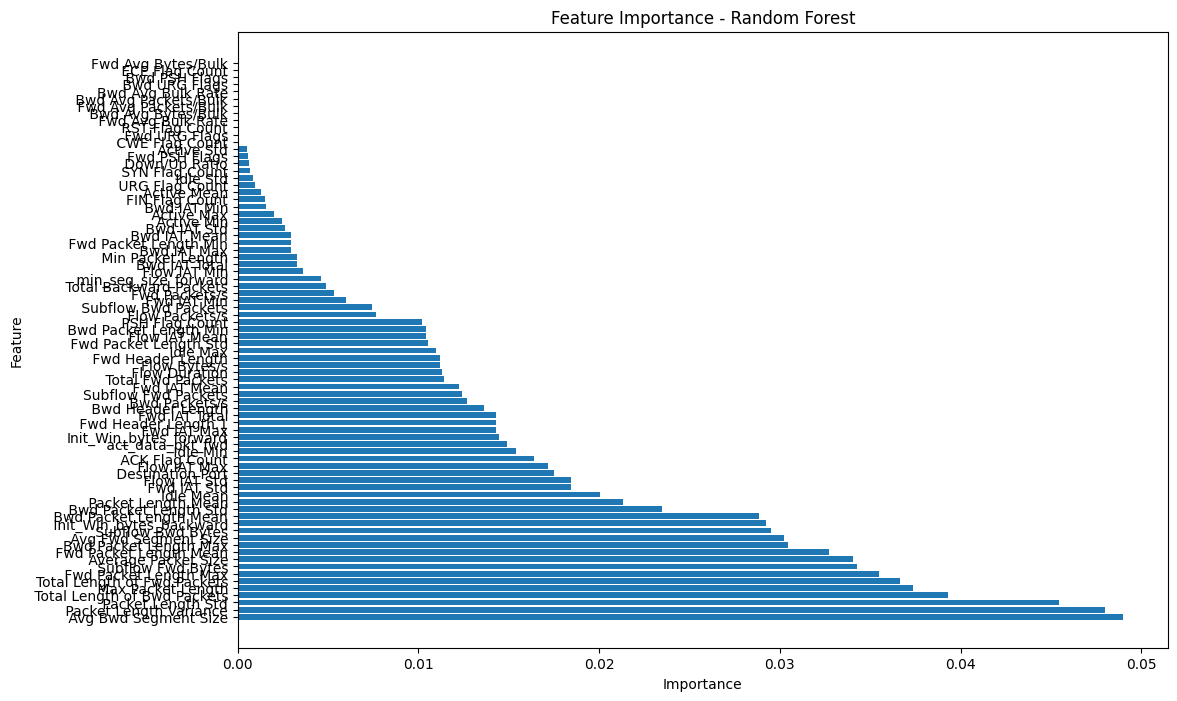

In [ ]:
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
top_k = 30
top_features = feature_importance_df['Feature'][:top_k].values

X_train_selected = X_train_normalised[top_features]
X_test_selected = X_test_normalised[top_features]
print("Top 30 features selected for model training:")
print(top_features)

Top 40 features selected for model training:
[' Avg Bwd Segment Size' ' Packet Length Variance' ' Packet Length Std'
 ' Total Length of Bwd Packets' ' Max Packet Length'
 'Total Length of Fwd Packets' ' Fwd Packet Length Max'
 ' Subflow Fwd Bytes' ' Average Packet Size' ' Fwd Packet Length Mean'
 'Bwd Packet Length Max' ' Avg Fwd Segment Size' ' Subflow Bwd Bytes'
 ' Init_Win_bytes_backward' ' Bwd Packet Length Mean'
 ' Bwd Packet Length Std' ' Packet Length Mean' 'Idle Mean' ' Fwd IAT Std'
 ' Flow IAT Std' ' Destination Port' ' Flow IAT Max' ' ACK Flag Count'
 ' Idle Min' ' act_data_pkt_fwd' 'Init_Win_bytes_forward' ' Fwd IAT Max'
 ' Fwd Header Length.1' 'Fwd IAT Total' ' Bwd Header Length'
 ' Bwd Packets/s' 'Subflow Fwd Packets' ' Fwd IAT Mean'
 ' Total Fwd Packets' ' Flow Duration' 'Flow Bytes/s' ' Fwd Header Length'
 ' Idle Max' ' Fwd Packet Length Std' ' Flow IAT Mean']


### Training Random Forest Model

In [ ]:
'''
rf_model = RandomForestClassifier(
	n_estimators=200,
	random_state=42,
	n_jobs=-1
)

rf_model.fit(X_train_selected, y_train_resampled)

y_pred = rf_model.predict(X_test_selected)
'''

#### GPU-Accelerated Model Training (XGBoost)
The cell below uses XGBoost with GPU acceleration for much faster training. XGBoost provides similar or better performance compared to RandomForest.

In [ ]:
# GPU-Accelerated model training using XGBoost
# This replaces RandomForest with XGBoost GPU for much faster training
import time
import xgboost as xgb

try:
    print("=" * 60)
    print("GPU-ACCELERATED MODEL TRAINING")
    print("=" * 60)
    print(f"\nTraining set shape: {X_train_selected.shape}")
    print(f"Number of classes: {len(np.unique(y_train_resampled))}")
    
    # XGBoost GPU classifier - functionally equivalent to RandomForest
    print("\nInitializing XGBoost with GPU acceleration...")
    rf_model = xgb.XGBClassifier(
        n_estimators=200,            # Same as your RandomForest
        tree_method='gpu_hist',      # USE GPU for tree construction
        predictor='gpu_predictor',   # USE GPU for prediction
        gpu_id=0,                    # Use first GPU (change if you have multiple)
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss',
        learning_rate=0.1,           # XGBoost learning rate
        max_depth=10,                # Max tree depth (prevents overfitting)
        subsample=0.8,               # Use 80% of data per tree (like bootstrap)
        colsample_bytree=0.8,        # Use 80% of features per tree
        n_jobs=-1,                   # Use all CPU cores for data loading
        verbosity=1                  # Show progress
    )
    
    # Train with timing
    print("\n" + "=" * 60)
    print("STARTING GPU TRAINING...")
    print("=" * 60)
    t0 = time.time()
    rf_model.fit(X_train_selected, y_train_resampled)
    train_time = time.time() - t0
    
    print(f"\n✓ GPU training completed!")
    print(f"  Training time: {train_time:.2f} seconds ({train_time/60:.2f} minutes)")
    
    # Make predictions with timing
    print("\n" + "=" * 60)
    print("MAKING PREDICTIONS...")
    print("=" * 60)
    t0 = time.time()
    y_pred = rf_model.predict(X_test_selected)
    pred_time = time.time() - t0
    
    print(f"\n✓ Predictions completed!")
    print(f"  Prediction time: {pred_time:.2f} seconds")
    print(f"  Total time: {train_time + pred_time:.2f} seconds")
    
    print("\n" + "=" * 60)
    print("GPU ACCELERATION SUCCESS!")
    print("=" * 60)
    print("\nNote: XGBoost GPU model is ready for evaluation.")
    print("      Run the next cell to see accuracy, precision, recall, and F1 score.")
    
except Exception as e:
    print("\n" + "=" * 60)
    print("⚠ GPU ACCELERATION FAILED")
    print("=" * 60)
    print(f"Error: {e}")
    print("\nPossible causes:")
    print("  1. XGBoost not built with GPU support")
    print("  2. CUDA drivers not installed or detected")
    print("  3. GPU memory insufficient")
    print("  4. GPU device not available")
    
    print("\nTo install GPU-enabled XGBoost on Windows:")
    print("  conda install -c conda-forge py-xgboost-gpu")
    print("  OR")
    print("  pip install xgboost (if CUDA is properly installed)")
    
    print("\nTo verify GPU availability, run:")
    print("  nvidia-smi")
    
    print("\n" + "=" * 60)
    print("FALLING BACK TO OPTIMIZED CPU TRAINING")
    print("=" * 60)
    
    from sklearn.ensemble import RandomForestClassifier
    
    rf_model = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1,                # Use all CPU cores
        max_samples=0.8,          # Bootstrap 80% for speed
        max_features='sqrt',      # Limit features per split
        min_samples_split=10,     # Speed optimization
        min_samples_leaf=4,       # Speed optimization
        max_depth=30,             # Limit depth
        verbose=1                 # Show progress
    )
    
    print("\nStarting CPU training...")
    t0 = time.time()
    rf_model.fit(X_train_selected, y_train_resampled)
    train_time = time.time() - t0
    
    print(f"\n✓ CPU training completed in {train_time:.2f} seconds ({train_time/60:.2f} minutes)")
    
    t0 = time.time()
    y_pred = rf_model.predict(X_test_selected)
    pred_time = time.time() - t0
    
    print(f"✓ Predictions completed in {pred_time:.2f} seconds")
    print(f"Total time: {train_time + pred_time:.2f} seconds")

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9983715487146938
Precision: 0.8635003725252548
Recall: 0.8742781591974423
F1 Score: 0.8614982109021334


In [ ]:
with open("rf_model.pkl", "wb") as f:
	pickle.dump(rf_model, f)
with open("scaler.pkl", "wb") as f:
	pickle.dump(scaler, f)
with open("feature_list.pkl", "wb") as f:
	pickle.dump(top_features, f)